# Robin Labs Module

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import ipywidgets as widgets
import os
import yaml

from src.robin.labs.entities import RobinLab

from pathlib import Path

path_config_supply = Path('../configs/ewgt23/supply_data.yml')
path_config_demand = Path('../configs/ewgt23/demand_data.yml')
path_config_labs = Path('../src/robin/labs/config.yml')
tmp_path = Path('../data/labs/tmp')

In [3]:
# Open Robin labs default config
with open(path_config_labs, 'r') as f:
    config_labs = yaml.load(f, Loader=yaml.SafeLoader)
    
print(config_labs)

{'seed': 10, 'supply': [{'prices': 'default'}, {'capacities': 'default'}, {'capacity_constraints': 'default'}, {'services': 'default'}], 'demand': [{'passengers': 'default'}, {'markets': 'default'}, {'user_types': 'default'}]}


In [ ]:
# Prices range widget
print("Prices: ")
prices_range = {"min": 0, "max": 500, "step": 1.0}
range_widget = widgets.FloatRangeSlider(value=[0, 350], **prices_range, description='Price increase range: ')
container = widgets.HBox([range_widget])
display(container)

step_range = {"min": 0, "max": 10.0, "step": 0.1}
step_widget = widgets.BoundedFloatText(value=10.0, **step_range, description='Step (%): ')
container = widgets.HBox([step_widget])
display(container)

# Update config file
btn = widgets.Button(description='Update config')
display(btn)

def btn_eventhandler(obj):
    print('Updating config file...')
    
btn.on_click(btn_eventhandler)

In [5]:
lower_limit, upper_limit = range_widget.value
step = step_widget.value

print(f"Prices increase range: {lower_limit}% - {upper_limit}% with step {step}%")

In [4]:
robin_lab = RobinLab(path_config_supply=path_config_supply,
                     path_config_demand=path_config_demand,
                     tmp_path=tmp_path)

In [5]:
config = {"supply": {"start": 0, "stop": 200, "step": 10},
          "demand": (),
          "seed": 35}

robin_lab.set_lab_config(config=config)

100% (20 of 20) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [8]:
# Move seed to simulate method
robin_lab.simulate() # Run simulation

100% (20 of 20) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


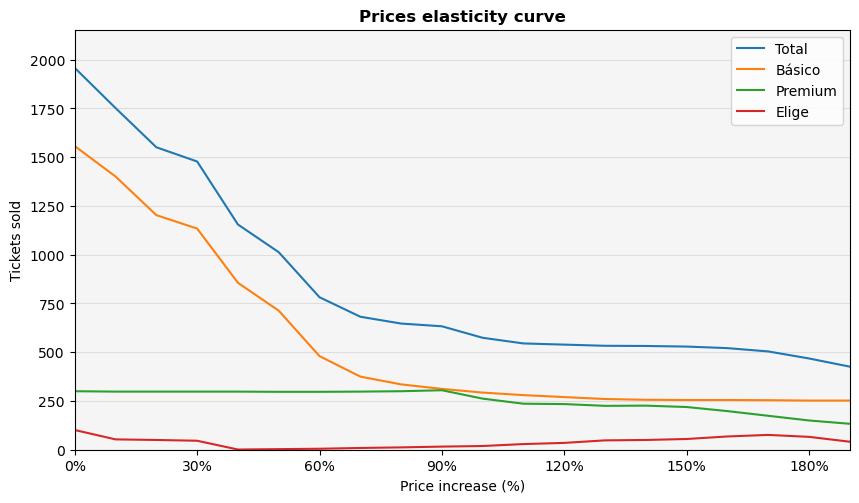

In [23]:
save_path = Path("../reports/figures/labs")

if not save_path.exists():
    os.mkdir(save_path)
    
robin_lab.plot_elasticity_curve(save_path=Path(save_path / "elasticity_curve_ewgt23.svg"))

In [12]:
a, b, c, d = robin_lab.get_kpis()

100% (20 of 20) |########################| Elapsed Time: 0:00:46 Time:  0:00:46
